## MNIST Image Classification with an MLP Model

### Import necessary packages

In [43]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from einops import rearrange, repeat, einsum
from torchvision import transforms
from tqdm import tqdm


### Build the dataset and dataloader

In [2]:
# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:02<00:00, 3.42MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 112kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.32MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.04MB/s]


### Visualize samples from the dataset

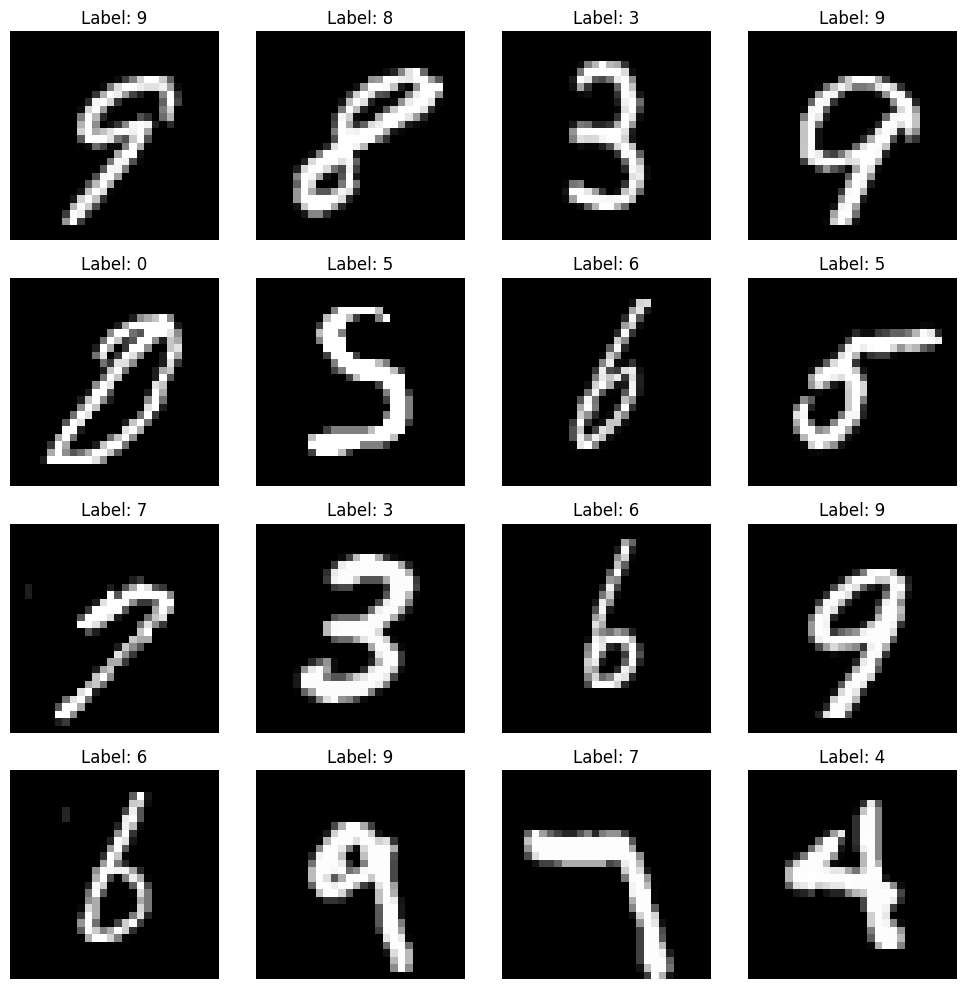

In [4]:
# Get 16 random indices
indices = np.random.choice(len(train_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

### Build an MLP Model

In [36]:
class EinopsLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        # create a docstring`` 
        super().__init__()
        self.weights = nn.Parameter(torch.empty(out_features, in_features))
        bound = 1 / math.sqrt(in_features)
        nn.init.uniform_(self.weights, -bound, +bound)
    
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
            nn.init.uniform_(self.bias, -bound, +bound)
        else:
            self.register_parameter("b", None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch, in_features).
            self.weights (torch.Tensor): Weight matrix of shape (out_features, in_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch, out_features), equivalent to x @ W.T.
        """
        y = einsum(x, self.weights, "b i, o i -> b o")
        if self.bias is not None:
            y = y + self.bias
        return y


In [38]:
class EinopsMLP(nn.Module):
    def __init__(self, in_hw=(28, 28), hidden=128, num_classes=10):
        super().__init__()
        h, w = in_hw
        self.in_dim = h * w
        self.fc1 = EinopsLinear(self.in_dim, hidden)
        self.fc2 = EinopsLinear(hidden, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (b, 1, 28, 28)
        x = rearrange(x, "b c h w -> b (c h w)")  # flatten
        x = self.fc1(x)
        # ReLU without nn.ReLU / F.relu
        x = x.clamp(min=0)
        x = self.fc2(x)
        return x

In [ ]:
model = EinopsMLP()
x = torch.randn(64, 1, 28, 28)
print(model)
print(model(x).shape)

# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
# Use comma to print the number in a more readable format
print(f"Number of parameters: {num_params:,}")

EinopsMLP(
  (fc1): EinopsLinear()
  (fc2): EinopsLinear()
)
torch.Size([64, 10])
Number of parameters: 101,770


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [ ]:
num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")

 10%|█         | 1/10 [00:13<01:57, 13.08s/it]

Epoch: 1, Loss: 0.3827


 20%|██        | 2/10 [00:25<01:41, 12.68s/it]

Epoch: 2, Loss: 0.1984


 30%|███       | 3/10 [00:38<01:29, 12.78s/it]

Epoch: 3, Loss: 0.1402


 40%|████      | 4/10 [00:50<01:15, 12.62s/it]

Epoch: 4, Loss: 0.1151


 50%|█████     | 5/10 [01:03<01:02, 12.56s/it]

Epoch: 5, Loss: 0.0968


 60%|██████    | 6/10 [01:16<00:50, 12.70s/it]

Epoch: 6, Loss: 0.0846


 70%|███████   | 7/10 [01:29<00:38, 12.85s/it]

Epoch: 7, Loss: 0.0754


 80%|████████  | 8/10 [01:41<00:25, 12.76s/it]

Epoch: 8, Loss: 0.0662


 90%|█████████ | 9/10 [01:54<00:12, 12.66s/it]

Epoch: 9, Loss: 0.0632


100%|██████████| 10/10 [02:07<00:00, 12.73s/it]

Epoch: 10, Loss: 0.0572


In [42]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9747


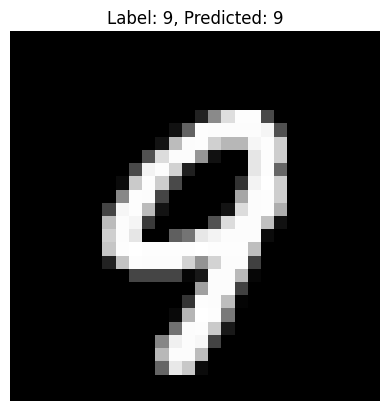

In [22]:
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Move the image to the device
image = image.to(device)

# Forward pass to get the predicted label
output = model(image.unsqueeze(0))
_, predicted_label = torch.max(output, 1)

# Convert the image tensor to a numpy array
image_np = image.cpu().numpy()

# Display the image, its label, and the predicted label
plt.imshow(image_np.squeeze(), cmap='gray')
plt.title(f"Label: {label}, Predicted: {predicted_label.item()}")
plt.axis('off')
plt.show()